# Noise reduction + wavelet transform

**In this notebook, I decompose the signals using a Wavelet Transform (WT) from which entropy measures are computed and stored in a dataframe**

Inspired from a Kaggle notebook -> https://www.kaggle.com/kiran3799/epilepsy-prediction-notebook

and from a paper -> https://journals.sagepub.com/doi/10.1177/1550147720911009

## Overall process

From each segments:

* Noise reduction using ICA algorithm (fastICA from sklearn)
* Wavelet transform
* Features extraction (mean absolute value, average power, standard deviation, variance, mean, skewness, and Shannon entropy)
* Classification (KNN, SVM, ...)

## Imports

In [17]:
import pywt
import os
import random
import numpy as np
from pyentrp import entropy
from scipy.stats import median_absolute_deviation
from sklearn.preprocessing import RobustScaler
import pandas as pd
import scipy.io
from sklearn.decomposition import FastICA
from scipy.signal import spectrogram
from scipy.signal import resample
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Load test data

In [2]:
interictal_test = pd.read_csv(os.path.join(os.getcwd(),'../raw_data/Patient_1_csv/train_segments_unlabelled/interictal_segment_50.csv'))
preictal_test = pd.read_csv(os.path.join(os.getcwd(),'../raw_data/Patient_1_csv/train_segments_unlabelled/preictal_segment_1.csv'))

In [105]:
interictal_test

,0,1,2,3,4,5,6,7,8,9,...,29990,29991,29992,29993,29994,29995,29996,29997,29998,29999
0,11.205265,167.071511,75.419953,162.286907,211.937037,153.678963,177.927322,166.478143,192.856010,221.013682,...,-44.464473,-71.423095,-80.289187,-107.851673,-169.742237,-208.624011,-171.272735,-66.927319,-72.434430,-58.139543
1,-132.270116,-55.462781,-170.133062,-41.973859,-38.518123,-146.716251,-98.169147,-119.221746,-49.319147,71.344001,...,511.624613,505.597751,522.420786,417.045427,341.989907,329.557642,315.109625,417.620291,333.218627,231.127537
2,-38.381349,182.387193,102.018862,133.921966,160.131290,134.429295,156.295005,137.161324,151.880594,163.515580,...,-291.956694,-274.804727,-285.771946,-328.505936,-366.997749,-356.998013,-319.989103,-272.702536,-297.534086,-280.593203
3,254.676796,483.462039,369.077160,382.093638,414.483458,377.479944,392.027705,397.471578,427.565397,423.449111,...,-798.001707,-774.993283,-829.218513,-906.712882,-932.956457,-906.870225,-849.384170,-792.310151,-823.089521,-813.866863
4,259.512509,475.155292,297.151224,311.565135,372.448171,324.682749,330.145081,357.385271,394.372344,374.583463,...,-108.598073,-63.119489,-160.522970,-250.015801,-238.096238,-183.450695,-125.356757,-100.697214,-158.033309,-170.755953
5,-108.691805,89.376643,-91.510470,-29.725325,74.473647,-24.807673,-30.473806,28.805531,11.374653,-9.575394,...,-20.341383,3.695764,-27.755152,-103.275057,-142.930701,-98.001178,-64.335238,-83.001875,-185.856318,-143.352013
6,-78.698705,148.597153,4.763668,31.593416,130.054188,85.724617,15.268165,-2.596932,27.953226,48.366592,...,-15.581861,0.809452,1.709389,-49.762471,-40.169091,37.832258,106.834298,85.736617,-17.522502,85.009995
7,-192.692623,-22.911015,-71.770231,-40.193443,-40.470570,-55.996200,-40.259621,-28.114756,49.860002,93.056568,...,51.452991,65.907195,44.578905,2.429308,-11.581399,-7.387115,-21.243235,-10.204938,-51.602011,-11.856036
8,-152.768502,15.929824,-32.109384,9.253947,20.677217,14.317280,8.822953,-8.503969,37.214743,49.087693,...,71.142562,106.754314,97.186894,52.406715,44.971988,58.035849,40.996666,47.757031,4.695656,52.122731
9,-249.500044,-99.341681,-151.819794,-124.561997,-133.722044,-132.010851,-126.400307,-181.893931,-156.367988,-148.536080,...,368.891739,395.691218,359.220880,327.185584,351.615637,339.494176,314.753123,344.268810,292.457227,305.484071


## ICA noise reduction

In [59]:
pwd

'/Users/commander/code/jhupiterz/SafeSeizure/notebooks'

In [53]:
ica_transformer = FastICA(n_components=15,random_state=0)
interictal_transformed = ica_transformer.fit_transform(interictal_test)
preictal_transformed = ica_transformer.fit_transform(preictal_test)

In [54]:
interictal_transformed

array([[ 2.79559186e-01, -2.72092172e-01, -2.93809897e-01,
        -3.12203227e-01,  2.65401851e-01, -2.96260961e-01,
         2.79149444e-01, -2.11194814e-01, -2.28483027e-01,
         7.10395767e-02,  2.68024737e-01,  2.76339180e-01,
         2.84082435e-01,  3.00091901e-01, -2.90982277e-02],
       [ 1.79062512e-01,  2.92113101e-01, -3.08715934e-01,
         2.91760481e-01,  1.52991476e-01,  1.52342329e-01,
        -2.54847394e-01,  3.23011096e-01,  3.04796664e-01,
         8.26555669e-02,  3.61381670e-01, -2.21572231e-01,
         2.61350004e-01,  2.86239960e-01, -3.27848201e-02],
       [ 2.97732693e-01, -3.09317140e-01,  3.15892124e-01,
         2.30696925e-01, -2.98271380e-01,  3.18041634e-01,
        -2.66686402e-01, -1.40942337e-01, -2.26789160e-01,
         6.93938079e-02,  3.24155613e-01,  2.50142453e-01,
        -2.90652672e-01,  2.81857052e-01, -2.80064766e-02],
       [ 3.42711023e-01,  3.58339856e-01,  3.24146259e-01,
        -3.48856171e-01,  3.13375124e-01, -3.30743183

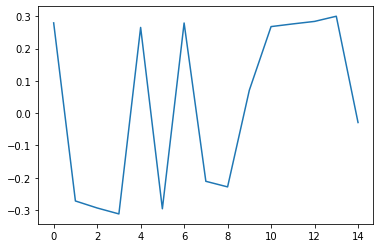

In [55]:
plt.plot(interictal_transformed[0])

## Discrete Wavelet Transform

In [56]:
wavelet = pywt.Wavelet('db4')
coeffs = pywt.wavedec(interictal_transformed, wavelet, level = 2)

In [57]:
np.array(coeffs).shape

ValueError: could not broadcast input array from shape (15,9) into shape (15)

## Feature extraction

In [12]:
# mean absolute value, average power, standard deviation, variance, mean, skewness, and Shannon entropy

In [58]:
def flatten_list(l):
    flat_list = []
    for sublist in l:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [59]:
def mean_absolute_value(array):
    absolute_values = []
    for i in range(len(array)):
        absolute_values.append(abs(array[i]))
    mean_absolute_value = np.asarray(absolute_values).sum()*(1/len(array))
    #print(mean_absolute_value)
    return mean_absolute_value

In [60]:
def average_power(array):
    average_power_values = []
    for i in range(len(array)):
        average_power_values.append(abs(array[i])**2)
    average_power_value = np.asarray(average_power_values).sum()*(1/len(array))
    #print(average_power_value)
    return average_power_value

In [61]:
def shan(d1):
    sh1=[]
    d1=np.rint(d1)
    for i in range(d1.shape[0]):
        X=d1[i]
        sh1.append(entropy.shannon_entropy(X))
    return(sh1)

In [64]:
def feature_extraction(decomposed_signals):
    mav = []
    avp = []
    std = []
    var = []
    mean = []
    for coeff in decomposed_signals:
        mav_electrode = []
        avp_electrode = []
        std_electrode = []
        var_electrode = []
        mean_electrode = []
        for electrode in coeff:
            mav_electrode.append(mean_absolute_value(electrode))
            avp_electrode.append(average_power(electrode))
            std_electrode.append(np.std(electrode))
            var_electrode.append(np.var(electrode))
            mean_electrode.append(np.mean(electrode))
        mav.append(mav_electrode)
        avp.append(avp_electrode)
        std.append(std_electrode)
        var.append(var_electrode)
        mean.append(mean_electrode)
    mav = flatten_list(mav)
    avp = flatten_list(avp)
    std = flatten_list(std)
    var = flatten_list(var)
    mean = flatten_list(mean)
    shan_ent = []
    for i in range(len(decomposed_signals)):
        shan_ent.append(shan(coeffs[i]))
    shan_ent = flatten_list(shan_ent)
    data = np.vstack((np.array(mav), np.array(avp), 
                     np.array(std), np.array(var), np.array(mean), np.array(shan_ent)))
    #data = pd.DataFrame(data)
    features = data.T
    #features.columns = ['mean_abs_value', 'average_power', 'std', 'var', 'mean', 'shannon_entropy']

    return features

In [65]:
feature_extraction(coeffs).shape

(45, 6)

## Feature extraction for all Dog_csv files

In [297]:
dirs = ['Dog_1_csv', 'Dog_2_csv', 'Dog_3_csv', 'Dog_4_csv', 'Dog_5_csv']

In [299]:
ica_transformer = FastICA(n_components= 10, max_iter= 3000000, random_state=0, tol=0.1)
wavelet = pywt.Wavelet('db4')
# For each Dog_csv file: (1) create list of files -> (2) reads each file
#                        (3) ICA Transform -> (4) DWT -> (5) Extracts features
#                        (4) Creates target column
for directory in dirs:
    folder_path = f'/Users/commander/code/jhupiterz/SafeSeizure/raw_data/{directory}'
    files = []
    data = []
    y = []
    for f in os.listdir(folder_path):
        if f.startswith('preictal') | f.startswith('interictal'):
            files.append(f)
    #print(files)
    features = []
    target = []
    for file in files:
        segment = pd.read_csv(os.path.join(folder_path, file))
        if (directory == 'Dog_1_csv') | (directory == 'Dog_2_csv') | (directory == 'Dog_3_csv') | (directory == 'Dog_4_csv'):
            segment.drop([15], axis = 0, inplace = True)
        segment_transformed = ica_transformer.fit_transform(segment)
        coeffs = pywt.wavedec(segment_transformed, wavelet, level = 7)
        segment_features = feature_extraction(coeffs)
        np.asarray(features.append(segment_features))
        if file.startswith('interictal'):
            target.append(0)
        elif file.startswith('preictal'):
            target.append(1)
        if directory == 'Dog_1_csv':
            features_dog1 = features
            target_dog1 = target
        elif directory == 'Dog_2_csv':
            features_dog2 = features
            target_dog2 = target
        elif directory == 'Dog_3_csv':
            features_dog3 = features
            target_dog3 = target
        elif directory == 'Dog_4_csv':
            features_dog4 = features
            target_dog4 = target
        elif directory == 'Dog_5_csv':
            features_dog5 = features
            target_dog5 = target
        #elif directory == 'Patient_1_csv':
            #features_pat = features
            #target_pat = target
    target = pd.Series(np.array(target))
data = np.vstack((features_dog1, features_dog2, features_dog3, features_dog4, features_dog5))
y = pd.concat([pd.Series(target_dog1), pd.Series(target_dog2), pd.Series(target_dog3), 
               pd.Series(target_dog4), pd.Series(target_dog5)], 
              axis = 0, ignore_index = True)#pd.Series(target_dog4)], axis = 0, ignore_index = True)
X = data.reshape(len(data),-1)
print(len(X), len(y))

3939 3939


In [300]:
from sklearn.preprocessing import RobustScaler
robust = RobustScaler()

robust.fit_transform(X)
X.shape

(3939, 720)

## Logistic regression

In [301]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

log_reg = LogisticRegression()
sm = SMOTE(random_state=42)
#undersample = NearMiss(version=3, n_neighbors_ver3=3)

#X_resampled, y_resampled = undersample.fit_resample(X, y)

X_resampled, y_resampled = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)

cv_results = cross_validate(log_reg, X_resampled, y_resampled, cv=5, scoring=['recall',
                                                                              'accuracy', 'f1', 'precision'])
cv_results

{'fit_time': array([0.43757606, 0.45382285, 0.46418381, 0.48347116, 0.58247972]),
 'score_time': array([0.00895405, 0.00813007, 0.00822997, 0.00828385, 0.00929213]),
 'test_recall': array([0.85306122, 0.86122449, 0.85986395, 0.86239782, 0.8829932 ]),
 'test_accuracy': array([0.72993197, 0.77823129, 0.79047619, 0.71477195, 0.72906739]),
 'test_f1': array([0.75953967, 0.79522613, 0.80407125, 0.75133531, 0.76533019]),
 'test_precision': array([0.68449782, 0.7386231 , 0.75507766, 0.66561514, 0.67533819])}

In [302]:
log_reg.fit(X_train, y_train)

LogisticRegression()

In [303]:
y_pred = log_reg.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[808, 306],
       [130, 961]])

## Support Vector Machines

### Linear kernel

In [212]:
from sklearn.svm import SVC

svc_linear = SVC(kernel='linear')
cv_results = cross_validate(svc_linear, X_resampled, y_resampled, cv=5, scoring=['recall',
                                                                                 'accuracy', 'f1', 'precision'])
cv_results

{'fit_time': array([10.62414503,  9.61282206, 10.06064105,  9.79077411,  8.473001  ]),
 'score_time': array([0.57969093, 0.54313397, 0.59933376, 0.55881667, 0.47154999]),
 'test_recall': array([0.9255814 , 0.94108527, 0.9255814 , 0.92080745, 0.95658915]),
 'test_accuracy': array([0.77906977, 0.79922481, 0.82325581, 0.83785881, 0.65166796]),
 'test_f1': array([0.80730223, 0.82416836, 0.83966245, 0.85017921, 0.7332145 ]),
 'test_precision': array([0.71582734, 0.73309179, 0.76833977, 0.78961385, 0.59441233])}

In [116]:
cv_results['test_recall'].mean()
cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_precision'].mean()

0.7202570147035653

In [213]:
svc_linear.fit(X_train, y_train)

SVC(kernel='linear')

In [214]:
y_pred = svc_linear.predict(X_test)
print(y_pred.sum(), y_test.sum())

0 97


### Polynomial kernel

In [215]:
svc_poly = SVC(kernel='poly')
cv_results = cross_validate(svc_poly, X_resampled, y_resampled, cv=5, scoring=['recall',
                                                                               'accuracy', 'f1', 'precision'])
cv_results

{'fit_time': array([4.77452111, 4.7026422 , 4.75146508, 4.85962892, 4.3721149 ]),
 'score_time': array([0.5463438 , 0.52520967, 0.54805231, 0.56480098, 0.46261001]),
 'test_recall': array([0.99844961, 0.99844961, 0.99224806, 1.        , 1.        ]),
 'test_accuracy': array([0.93953488, 0.9496124 , 0.95426357, 0.96276183, 0.84561676]),
 'test_f1': array([0.94289898, 0.95195861, 0.95593727, 0.96407186, 0.86635326]),
 'test_precision': array([0.89320388, 0.90960452, 0.9221902 , 0.93063584, 0.76421801])}

In [123]:
cv_results['test_recall'].mean()
cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_precision'].mean()

0.8839704905254451

In [216]:
svc_poly.fit(X_train, y_train)

SVC(kernel='poly')

In [217]:
y_pred = svc_poly.predict(X_test)
print(y_pred.sum(), y_test.sum())

0 97


## KNeighbors Classifier

In [218]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

cv_results = cross_validate(knn, X_resampled, y_resampled, cv=5, scoring=['recall', 
                                                                          'accuracy', 'f1', 'precision'])
cv_results

{'fit_time': array([0.00960898, 0.0085218 , 0.00706315, 0.00710821, 0.00708103]),
 'score_time': array([0.21227312, 0.16280913, 0.15980482, 0.16034484, 0.15578914]),
 'test_recall': array([1., 1., 1., 1., 1.]),
 'test_accuracy': array([0.64108527, 0.64728682, 0.66434109, 0.66718386, 0.60279286]),
 'test_f1': array([0.73588135, 0.73925501, 0.74869414, 0.7501456 , 0.71587125]),
 'test_precision': array([0.58212996, 0.58636364, 0.59833024, 0.60018639, 0.55747623])}

In [92]:
cv_results['test_recall'].mean()
cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_precision'].mean()

0.5784173413596911

In [219]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [220]:
y_pred = knn.predict(X_test)
print(y_pred.sum(), y_test.sum())

1 97


## Ensemble classifiers

In [221]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=10)

cv_results = cross_validate(random_forest, X_resampled, y_resampled, cv=5, scoring=['recall',
                                                                                    'accuracy', 'f1', 'precision'])
cv_results

{'fit_time': array([0.64362407, 0.71046209, 0.69872212, 0.818506  , 0.63013816]),
 'score_time': array([0.00906897, 0.00801611, 0.01356888, 0.00679207, 0.00637889]),
 'test_recall': array([0.80620155, 0.97829457, 0.98139535, 0.99068323, 0.98449612]),
 'test_accuracy': array([0.89069767, 0.9751938 , 0.98604651, 0.98913887, 0.94181536]),
 'test_f1': array([0.88060965, 0.97527048, 0.98598131, 0.98914729, 0.94423792]),
 'test_precision': array([0.97014925, 0.97226502, 0.99061033, 0.9876161 , 0.90714286])}

In [128]:
cv_results['test_recall'].mean()
cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_precision'].mean()

0.9650367402741272

In [222]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [223]:
y_pred = random_forest.predict(X_test)
print(y_pred.sum(), y_test.sum())

0 97


In [102]:
for index, output in enumerate(y_pred):
    if output == np.array(y_test)[index]:
        print('Identified')
    else:
        print('Misidentified')

Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Misidentified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Misidentified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Iden

Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Misidentified
Identified
Identified
Misidentified
Misidentified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Misidentified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identified
Identifie

In [224]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[804,   0],
       [ 97,   0]])

## Test on Dog 5 and/or Patient 1

In [189]:
# Builds list of files for Dog_5
folder_path = '/Users/commander/code/jhupiterz/SafeSeizure/raw_data/Dog_5_csv'
files_Dog5 = []

for f in os.listdir(folder_path):
    if f.startswith('preictal') | f.startswith('interictal'):
        files_Dog5.append(f)
len(files_Dog5)

480

In [190]:
features_5 = []
target_5 = []
for file in files_Dog5:
    segment = pd.read_csv(os.path.join(folder_path, file))
    #segment_scaled = robust_scaler.fit_transform(segment)
    segment_transformed = ica_transformer.fit_transform(segment)
    coeffs = pywt.wavedec(segment_transformed, wavelet, level = 7)
    segment_features = feature_extraction(coeffs)
    np.asarray(features_5.append(segment_features))
    if file.startswith('interictal'):
        target_5.append(0)
    elif file.startswith('preictal'):
        target_5.append(1)
    #print(file)
print(len(features_5), (features_5[0].shape), len(target_5))
features_dog5 = np.asarray(features_5)
X_dog5 = features_dog5.reshape(len(features_dog5),-1)
y_dog5 = target_5

480 (120, 6) 480


### Logistic regression

In [193]:
y_pred = log_reg.predict(X_dog5)
confusion_matrix(y_dog5, y_pred)

array([[345, 105],
       [ 27,   3]])

In [194]:
y_pred = random_forest.predict(X_dog5)
confusion_matrix(y_dog5, y_pred)

array([[448,   2],
       [ 29,   1]])

In [196]:
y_pred = svc_linear.predict(X_dog5)
confusion_matrix(y_dog5, y_pred)

array([[333, 117],
       [ 26,   4]])

In [197]:
y_pred = svc_poly.predict(X_dog5)
confusion_matrix(y_dog5, y_pred)

array([[417,  33],
       [ 26,   4]])

In [200]:
y_pred = knn.predict(X_dog5)
confusion_matrix(y_dog5, y_pred)

array([[137, 313],
       [  8,  22]])

In [184]:
for index, output in enumerate(y_pred):
    if output == 1 and np.array(y_dog5)[index] == 1:
        print('True positive')
    elif output == 0 and np.array(y_dog5)[index] == 1:
        print('False negative')
    elif output == 1 and np.array(y_dog5)[index] == 0:
        print('False positive')
    elif output == 0 and np.array(y_dog5)[index] == 0:
        print('True negative')

True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
False positive
True negative
True negative
True negative
True negative
True negative
True negative
True negative
False positive
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
False positive
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
True negative
False positive
True negative
True negative
True negative
True negative
False positive
T